In [34]:
import os
from glob import glob
from datetime import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets 
import matplotlib.pyplot as plt

%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Hyperparameter Tunning

In [2]:
num_epochs = 20
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('../dataset/cifar/train/*.png')[:500]
test_paths = glob('../dataset/cifar/test/*.png')[:500]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
# train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(load_image_label)
# train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
# test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(load_image_label)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

### Checkpoint

In [19]:
save_path = 'checkpoints'
check_point = tf.keras.callbacks.ModelCheckpoint(save_path,
                                                 monitor='val_accuracy',
                                                 vervose=1,
                                                 save_best_only=True, # val_accuracy가 올라갔을때만 저장
                                                 mode='max') 

### Training

In [22]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs,
    callbacks=[check_point]
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
15/15 [==============================] - 3s 123ms/step - loss: 1.2173 - accuracy: 0.5449 - val_loss: 1.8315 - val_accuracy: 0.3938
Epoch 2/20
15/15 [==============================] - 2s 131ms/step - loss: 1.2369 - accuracy: 0.5449 - val_loss: 1.8884 - val_accuracy: 0.3792
Epoch 3/20
15/15 [==============================] - 2s 143ms/step - loss: 1.1539 - accuracy: 0.5427 - val_loss: 1.8005 - val_accuracy: 0.3875
Epoch 4/20
15/15 [==============================] - 2s 151ms/step - loss: 1.1052 - accuracy: 0.5940 - val_loss: 1.9272 - val_accuracy: 0.4021
INFO:tensorflow:Assets written to: checkpoints\assets
Epoch 5/20
15/15 [==============================] - 2s 152ms/step - loss: 1.1135 - accuracy: 0.6042 - val_loss: 1.8980 - val_accuracy: 0.4167
INFO:tensorflow:Assets written to: checkpoints\assets
Epoch 6/20
15/15 [==============================] - 2s 147ms/step - loss: 1.0642 - accuracy: 0.5965 - val_loss: 1.8466 - val_accuracy: 0.3917
Epoch 7/20
15/15 [======================

### History

In [28]:
# history.history
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 15}

In [32]:
new_model = history.model

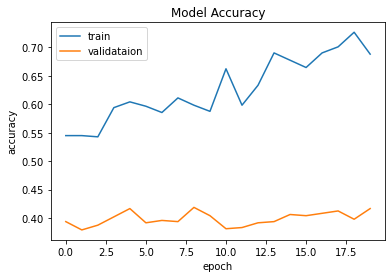

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validataion'])
plt.show()

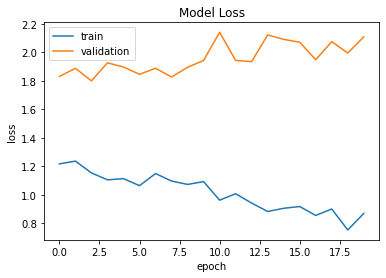

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()